# 1. Exploratory Data Analysis (EDA) – Tennis Match Outcomes

**Goal:**  
Explore the ATP match dataset and understand which factors (ranking, points, age, surface, etc.) are most strongly related to match outcomes.

In this notebook we:

1. Load raw ATP match data.
2. Clean and filter the dataset.
3. Define a **target variable**: whether the **stronger player (higher-ranked)** wins.
4. Create key features such as ranking difference, age difference and points difference.
5. Visualize relationships between features and the target.
6. Save a cleaned dataset for modeling: `clean_matches_tennis.csv`.


In [16]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.1)
pd.set_option("display.max_columns", 100)


## 1. Load Raw ATP Match Data

Here we read the raw ATP match results.  
You can use a **local CSV file** (e.g., `atp_matches_2019.csv`) or download from Jeff Sackmann's GitHub.


In [17]:
RAW_PATH = "./atp_matches_2019.csv"

if not os.path.exists(RAW_PATH):
    # 备选：从 Jeff Sackmann GitHub 下载 2019 年数据（仅作为备份方案）
    RAW_URL = "https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2019.csv"
    print(f"{RAW_PATH} not found locally, trying to load from GitHub...")
    df_raw = pd.read_csv(RAW_URL)
else:
    df_raw = pd.read_csv(RAW_PATH)

print("Raw shape:", df_raw.shape)
df_raw.head()


./atp_matches_2019.csv not found locally, trying to load from GitHub...
Raw shape: (2806, 49)


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2.0,NaN,Kei Nishikori,R,178.0,JPN,29.0,106421,4.0,NaN,Daniil Medvedev,R,198.0,RUS,22.8,6-4 3-6 6-2,3,F,124.0,3.0,3.0,77.0,44.0,31.0,17.0,13.0,3.0,6.0,8.0,6.0,100.0,54.0,34.0,20.0,14.0,10.0,15.0,9.0,3590.0,16.0,1977.0
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4.0,NaN,Daniil Medvedev,R,198.0,RUS,22.8,104542,NaN,PR,Jo-Wilfried Tsonga,R,188.0,FRA,33.7,7-6(6) 6-2,3,SF,82.0,10.0,1.0,52.0,33.0,28.0,14.0,10.0,0.0,1.0,17.0,2.0,77.0,52.0,36.0,7.0,10.0,10.0,13.0,16.0,1977.0,239.0,200.0
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2.0,NaN,Kei Nishikori,R,178.0,JPN,29.0,104871,NaN,NaN,Jeremy Chardy,R,188.0,FRA,31.8,6-2 6-2,3,SF,66.0,2.0,2.0,47.0,33.0,26.0,9.0,8.0,2.0,2.0,10.0,3.0,46.0,27.0,15.0,6.0,8.0,1.0,5.0,9.0,3590.0,40.0,1050.0
3,2019-M020,Brisbane,Hard,32,A,20181231,297,104542,NaN,PR,Jo-Wilfried Tsonga,R,188.0,FRA,33.7,200282,7.0,NaN,Alex De Minaur,R,183.0,AUS,19.8,6-4 7-6(2),3,QF,106.0,12.0,2.0,68.0,43.0,34.0,15.0,11.0,4.0,5.0,1.0,2.0,81.0,60.0,38.0,9.0,11.0,4.0,6.0,239.0,200.0,31.0,1298.0
4,2019-M020,Brisbane,Hard,32,A,20181231,296,106421,4.0,NaN,Daniil Medvedev,R,198.0,RUS,22.8,105683,5.0,NaN,Milos Raonic,R,196.0,CAN,28.0,6-7(2) 6-3 6-4,3,QF,129.0,12.0,3.0,105.0,68.0,48.0,25.0,16.0,8.0,8.0,29.0,5.0,94.0,56.0,46.0,19.0,15.0,2.0,4.0,16.0,1977.0,18.0,1855.0


## 2. Inspect Raw Data

Check columns, data types, and missing values.


In [18]:
df_raw.info()
df_raw[[
    "tourney_name", "surface", "tourney_level", "best_of",
    "winner_name", "winner_rank", "winner_rank_points", "winner_age",
    "loser_name",  "loser_rank",  "loser_rank_points",  "loser_age"
]].head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2806 entries, 0 to 2805
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          2806 non-null   object 
 1   tourney_name        2806 non-null   object 
 2   surface             2806 non-null   object 
 3   draw_size           2806 non-null   int64  
 4   tourney_level       2806 non-null   object 
 5   tourney_date        2806 non-null   int64  
 6   match_num           2806 non-null   int64  
 7   winner_id           2806 non-null   int64  
 8   winner_seed         1126 non-null   float64
 9   winner_entry        433 non-null    object 
 10  winner_name         2806 non-null   object 
 11  winner_hand         2806 non-null   object 
 12  winner_ht           2801 non-null   float64
 13  winner_ioc          2806 non-null   object 
 14  winner_age          2805 non-null   float64
 15  loser_id            2806 non-null   int64  
 16  loser_

,tourney_name,surface,tourney_level,best_of,winner_name,winner_rank,winner_rank_points,winner_age,loser_name,loser_rank,loser_rank_points,loser_age
0,Brisbane,Hard,A,3,Kei Nishikori,9.0,3590.0,29.0,Daniil Medvedev,16.0,1977.0,22.8
1,Brisbane,Hard,A,3,Daniil Medvedev,16.0,1977.0,22.8,Jo-Wilfried Tsonga,239.0,200.0,33.7
2,Brisbane,Hard,A,3,Kei Nishikori,9.0,3590.0,29.0,Jeremy Chardy,40.0,1050.0,31.8
3,Brisbane,Hard,A,3,Jo-Wilfried Tsonga,239.0,200.0,33.7,Alex De Minaur,31.0,1298.0,19.8
4,Brisbane,Hard,A,3,Daniil Medvedev,16.0,1977.0,22.8,Milos Raonic,18.0,1855.0,28.0


## 3. Data Cleaning

We keep only matches with complete information for:

- Winner / loser ranking (`winner_rank`, `loser_rank`)
- Winner / loser age (`winner_age`, `loser_age`)
- Ranking points (`winner_rank_points`, `loser_rank_points`)
- Basic match context: `surface`, `tourney_level`, `best_of`

We also remove invalid rankings (non-positive values).


In [19]:
cols_needed = [
    "tourney_id", "tourney_name", "surface", "draw_size",
    "tourney_level", "tourney_date", "match_num",
    "winner_name", "winner_id", "winner_rank", "winner_rank_points", "winner_age",
    "loser_name",  "loser_id",  "loser_rank",  "loser_rank_points",  "loser_age",
    "best_of"
]

df = df_raw[cols_needed].copy()


df = df.dropna(subset=[
    "winner_rank", "loser_rank",
    "winner_rank_points", "loser_rank_points",
    "winner_age", "loser_age",
    "surface", "tourney_level", "best_of"
])


df = df[(df["winner_rank"] > 0) & (df["loser_rank"] > 0)]

print("After basic cleaning:", df.shape)
df.head()


After basic cleaning: (2760, 18)


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_name,winner_id,winner_rank,winner_rank_points,winner_age,loser_name,loser_id,loser_rank,loser_rank_points,loser_age,best_of
0,2019-M020,Brisbane,Hard,32,A,20181231,300,Kei Nishikori,105453,9.0,3590.0,29.0,Daniil Medvedev,106421,16.0,1977.0,22.8,3
1,2019-M020,Brisbane,Hard,32,A,20181231,299,Daniil Medvedev,106421,16.0,1977.0,22.8,Jo-Wilfried Tsonga,104542,239.0,200.0,33.7,3
2,2019-M020,Brisbane,Hard,32,A,20181231,298,Kei Nishikori,105453,9.0,3590.0,29.0,Jeremy Chardy,104871,40.0,1050.0,31.8,3
3,2019-M020,Brisbane,Hard,32,A,20181231,297,Jo-Wilfried Tsonga,104542,239.0,200.0,33.7,Alex De Minaur,200282,31.0,1298.0,19.8,3
4,2019-M020,Brisbane,Hard,32,A,20181231,296,Daniil Medvedev,106421,16.0,1977.0,22.8,Milos Raonic,105683,18.0,1855.0,28.0,3


## 4. Define Target: Stronger Player Wins or Upset?

Instead of predicting whether a random "Player1" wins,  
we define a more meaningful target:

- **stronger_win = 1** → the higher-ranked player (smaller rank number) wins  
- **stronger_win = 0** → the lower-ranked player wins (**upset**)

This is similar to defining a **"hit"** song in Spotify tasks.
Here, the "positive" class is the expected outcome where the stronger player wins.


In [20]:
# stronger_rank: 较小的排名（数值小 = 排名更高）
df["stronger_rank"] = df[["winner_rank", "loser_rank"]].min(axis=1)
df["weaker_rank"]   = df[["winner_rank", "loser_rank"]].max(axis=1)

# stronger player 是否是 winner？
# 如果胜者排名更好 -> stronger player wins (stronger_win = 1)
df["stronger_win"] = (df["winner_rank"] <= df["loser_rank"]).astype(int)

# 看一下强者赢的比例
stronger_win_rate = df["stronger_win"].mean()
print(f"Stronger player win rate: {stronger_win_rate:.3f}")
df[["winner_name", "winner_rank", "loser_name", "loser_rank", "stronger_win"]].head()


Stronger player win rate: 0.614


,winner_name,winner_rank,loser_name,loser_rank,stronger_win
0,Kei Nishikori,9.0,Daniil Medvedev,16.0,1
1,Daniil Medvedev,16.0,Jo-Wilfried Tsonga,239.0,1
2,Kei Nishikori,9.0,Jeremy Chardy,40.0,1
3,Jo-Wilfried Tsonga,239.0,Alex De Minaur,31.0,0
4,Daniil Medvedev,16.0,Milos Raonic,18.0,1


## 5. Feature Engineering

We construct a few key features that reflect the strength gap between players:

- `rank_gap_abs`: absolute ranking gap (weaker_rank − stronger_rank)
- `points_diff`: ranking points difference (winner vs loser)
- `age_diff`: age difference between winner and loser

These features will be used both in EDA and in the modeling notebook.


In [21]:
# 排名差：弱者排名 - 强者排名（永远 >= 0）
df["rank_gap_abs"] = df["weaker_rank"] - df["stronger_rank"]

# 积分差：胜者积分 - 负者积分（用来观察强者是否也有更多积分）
df["points_diff"] = df["winner_rank_points"] - df["loser_rank_points"]

# 年龄差：胜者年龄 - 负者年龄（正数表示胜者更年长）
df["age_diff"] = df["winner_age"] - df["loser_age"]

df[["winner_name", "loser_name", "stronger_rank", "weaker_rank",
    "rank_gap_abs", "points_diff", "age_diff", "stronger_win"]].head()


,winner_name,loser_name,stronger_rank,weaker_rank,rank_gap_abs,points_diff,age_diff,stronger_win
0,Kei Nishikori,Daniil Medvedev,9.0,16.0,7.0,1613.0,6.2,1
1,Daniil Medvedev,Jo-Wilfried Tsonga,16.0,239.0,223.0,1777.0,-10.9,1
2,Kei Nishikori,Jeremy Chardy,9.0,40.0,31.0,2540.0,-2.8,1
3,Jo-Wilfried Tsonga,Alex De Minaur,31.0,239.0,208.0,-1098.0,13.9,0
4,Daniil Medvedev,Milos Raonic,16.0,18.0,2.0,122.0,-5.2,1


## 6. Descriptive Statistics and Distributions

We first look at basic statistics and distributions of the key features.


In [22]:
df[["stronger_rank", "weaker_rank", "rank_gap_abs", "points_diff", "age_diff"]].describe()


,stronger_rank,weaker_rank,rank_gap_abs,points_diff,age_diff
count,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000
mean,41.732609,104.846377,63.113768,636.220290,0.088152
std,45.979866,108.517598,87.872037,2201.377856,6.654163
min,1.000000,2.000000,1.000000,-10150.000000,-18.900000
25%,14.000000,51.000000,17.000000,-250.000000,-4.600000
50%,32.000000,78.000000,38.000000,222.500000,0.200000
75%,58.000000,118.000000,73.000000,928.000000,4.700000
max,922.000000,1491.000000,1280.000000,11967.000000,21.500000


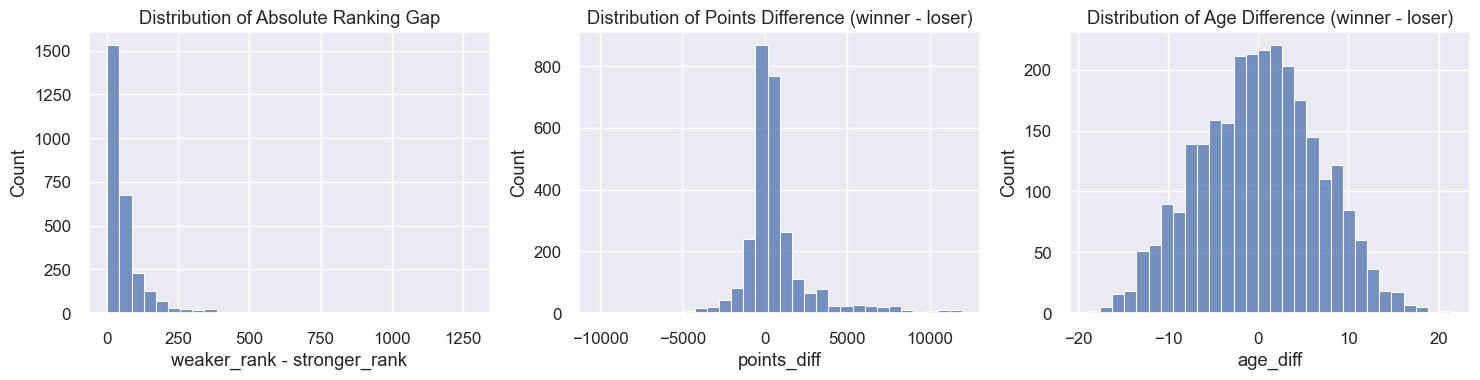

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.histplot(df["rank_gap_abs"], bins=30, ax=axes[0])
axes[0].set_title("Distribution of Absolute Ranking Gap")
axes[0].set_xlabel("weaker_rank - stronger_rank")

sns.histplot(df["points_diff"], bins=30, ax=axes[1])
axes[1].set_title("Distribution of Points Difference (winner - loser)")
axes[1].set_xlabel("points_diff")

sns.histplot(df["age_diff"], bins=30, ax=axes[2])
axes[2].set_title("Distribution of Age Difference (winner - loser)")
axes[2].set_xlabel("age_diff")

plt.tight_layout()
plt.show()


## 7. Stronger Win Rate vs Ranking Gap

We bin the absolute ranking gap into groups and compute the stronger player's win rate in each bin.

This helps visualize how often the stronger player wins when the ranking gap is small vs large.


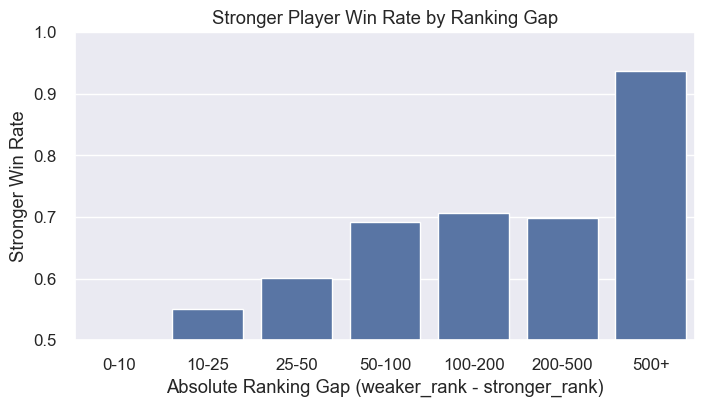

,rank_gap_bin,stronger_win
0,0-10,0.494949
1,10-25,0.550265
2,25-50,0.601124
3,50-100,0.692063
4,100-200,0.706452
5,200-500,0.697674
6,500+,0.937500


In [24]:
bins = [0, 10, 25, 50, 100, 200, 500, 1e9]
labels = ["0-10", "10-25", "25-50", "50-100", "100-200", "200-500", "500+"]

df["rank_gap_bin"] = pd.cut(
    df["rank_gap_abs"],
    bins=bins,
    labels=labels,
    right=False
)



win_rate_by_bin = (
    df.groupby("rank_gap_bin", observed=False)["stronger_win"]
      .mean()
      .reset_index()
)

plt.figure(figsize=(8, 4))
sns.barplot(data=win_rate_by_bin, x="rank_gap_bin", y="stronger_win")
plt.ylim(0.5, 1.0)
plt.ylabel("Stronger Win Rate")
plt.xlabel("Absolute Ranking Gap (weaker_rank - stronger_rank)")
plt.title("Stronger Player Win Rate by Ranking Gap")
plt.show()

win_rate_by_bin


## 8. Stronger Win Rate by Surface and Tournament Level

We also check how often the stronger player wins on different **surfaces** and at different **tournament levels**.


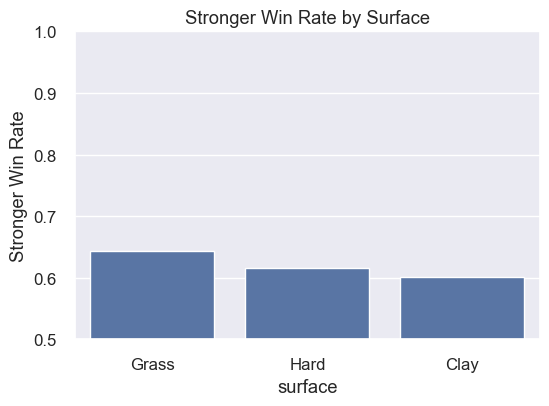

,surface,stronger_win
0,Grass,0.644172
1,Hard,0.615099
2,Clay,0.601467


In [25]:
surface_win_rate = (
    df.groupby("surface", observed=False)["stronger_win"]
      .mean()
      .sort_values(ascending=False)
      .reset_index()
)

plt.figure(figsize=(6, 4))
sns.barplot(data=surface_win_rate, x="surface", y="stronger_win")
plt.ylim(0.5, 1.0)
plt.ylabel("Stronger Win Rate")
plt.title("Stronger Win Rate by Surface")
plt.show()

surface_win_rate


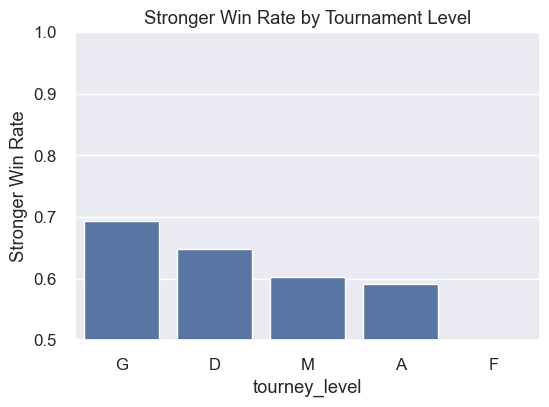

,tourney_level,stronger_win
0,G,0.693676
1,D,0.647887
2,M,0.603175
3,A,0.591419
4,F,0.500000


In [26]:
level_win_rate = (
    df.groupby("tourney_level", observed=False)["stronger_win"]
      .mean()
      .sort_values(ascending=False)
      .reset_index()
)

plt.figure(figsize=(6, 4))
sns.barplot(data=level_win_rate, x="tourney_level", y="stronger_win")
plt.ylim(0.5, 1.0)
plt.ylabel("Stronger Win Rate")
plt.title("Stronger Win Rate by Tournament Level")
plt.show()

level_win_rate


## 9. Correlation Heatmap

We compute the correlation between numeric features and the target `stronger_win`:

- `rank_gap_abs`
- `points_diff`
- `age_diff`
- `stronger_win`


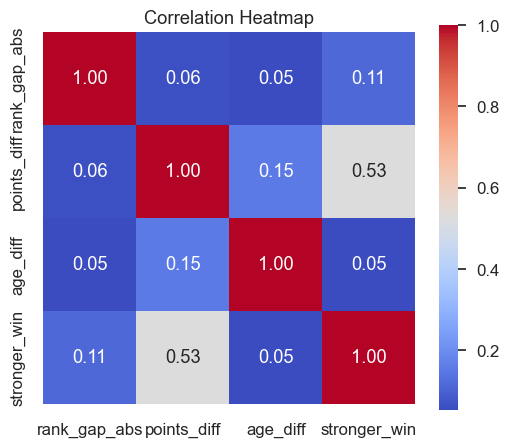

,rank_gap_abs,points_diff,age_diff,stronger_win
rank_gap_abs,1.000000,0.063022,0.052455,0.113057
points_diff,0.063022,1.000000,0.154323,0.527831
age_diff,0.052455,0.154323,1.000000,0.053887
stronger_win,0.113057,0.527831,0.053887,1.000000


In [27]:
corr_cols = ["rank_gap_abs", "points_diff", "age_diff", "stronger_win"]
corr = df[corr_cols].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Heatmap")
plt.show()

corr


## 11. Save Cleaned Dataset for Modeling

We now save a cleaned version of the dataset containing:

- match context
- engineered features
- target variable `stronger_win`

This file will be used in the **Modeling** notebook.


In [28]:
df_model = df[[
    "tourney_id", "tourney_name", "surface", "draw_size",
    "tourney_level", "tourney_date", "match_num",
    "winner_name", "winner_id", "winner_rank", "winner_rank_points", "winner_age",
    "loser_name",  "loser_id",  "loser_rank",  "loser_rank_points",  "loser_age",
    "stronger_rank", "weaker_rank",
    "rank_gap_abs", "points_diff", "age_diff",
    "best_of",
    "stronger_win",
]]

SAVE_PATH = "clean_matches_tennis.csv"
df_model.to_csv(SAVE_PATH, index=False)
print("Saved cleaned dataset for modeling to:", SAVE_PATH)
print("Final shape:", df_model.shape)


Saved cleaned dataset for modeling to: clean_matches_tennis.csv
Final shape: (2760, 24)
